<a href="https://colab.research.google.com/github/AeroEng16/FootballAnalysis/blob/main/dataAnalysisWorldCupAndEurosData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  from statsbombpy import sb
except ModuleNotFoundError:
  !pip install statsbombpy
  from statsbombpy import sb
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from bs4 import BeautifulSoup
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime, time
from itertools import chain
import csv
from ast import literal_eval
import math
pd.options.mode.chained_assignment = None  # default='warn'
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
pd.set_option('display.max_rows', 99999)
pd.set_option('max_colwidth', 400)

import requests
import re
import json
import plotly.graph_objects as go
from PIL import Image, ImageDraw
from io import BytesIO
import yaml
import os
;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.3 MB/s eta 0:00:00
Mounted at /content/drive


''

In [2]:
URL = 'https://www.fifa.com/fifa-world-ranking/men';

headers = requests.utils.default_headers()
headers.update({
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0',
})

r = requests.get(URL,headers = headers)

soup = BeautifulSoup(r.content, 'html5lib') # If this line causes an error, run 'pip install html5lib' or install html5lib

table = soup.find('script', attrs = {'id':'__NEXT_DATA__'})
data = json.loads(table.contents[0])

idDateList = data['props']['pageProps']['pageData']['ranking']['dates']

dateIdDict = {}

for i in range(0,len(idDateList)):
  for j in range(0,len(idDateList[i]['dates'])):

    dateIdDict[idDateList[i]['dates'][j]['matchWindowEndDate']] = idDateList[i]['dates'][j]['id']

baseURL = 'https://inside.fifa.com/api/ranking-overview?locale=en&dateId=DATEID&rankingType=football'

internationalRankingsDf = pd.DataFrame(columns = ['Country','Rank','Elo','Date'])

for k in dateIdDict.keys():

  resp = requests.get(baseURL.replace('DATEID',dateIdDict[k]),headers = headers)
  data = json.loads(resp.content)


  for i in data['rankings']:
    internationalRankingsDf.loc[len(internationalRankingsDf.index)] = [i['rankingItem']['name'],i['rankingItem']['rank'],i['rankingItem']['totalPoints'],k]

internationalRankingsDf.head(10)

Country Rank      Elo        Date
0    Argentina    1  1867.25  2024-12-15
1       France    2  1859.78  2024-12-15
2        Spain    3  1853.27  2024-12-15
3      England    4  1813.81  2024-12-15
4       Brazil    5  1775.85  2024-12-15
5     Portugal    6  1756.12  2024-12-15
6  Netherlands    7  1747.55  2024-12-15
7      Belgium    8  1740.62  2024-12-15
8        Italy    9  1731.51  2024-12-15
9      Germany   10  1703.79  2024-12-15

In [ ]:
fig = px.line(internationalRankingsDf,x = 'Date',y = 'Elo', color = 'Country')
fig.show()

# Data Available Exploration

In [3]:
comps = sb.competitions()
available360Data = comps[~comps['match_available_360'].isnull()]


/usr/local/lib/python3.11/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [4]:
mensWCMatches = sb.matches(competition_id=43, season_id=106)
mensEuros24 =sb.matches(competition_id = 55, season_id = 282)
mensEuros20 =sb.matches(competition_id = 55, season_id = 43)
allMatches = pd.concat([mensWCMatches,mensEuros24,mensEuros20])

/usr/local/lib/python3.11/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [5]:
mensEuros20.head()


match_id  match_date      kick_off         competition season    home_team  \
0   3795108  2021-07-02  18:00:00.000  Europe - UEFA Euro   2020  Switzerland   
1   3788769  2021-06-21  21:00:00.000  Europe - UEFA Euro   2020       Russia   
2   3788766  2021-06-20  18:00:00.000  Europe - UEFA Euro   2020        Italy   
3   3795220  2021-07-06  21:00:00.000  Europe - UEFA Euro   2020        Italy   
4   3788761  2021-06-18  15:00:00.000  Europe - UEFA Euro   2020       Sweden   

  away_team  home_score  away_score match_status  ...  \
0     Spain           1           1    available  ...   
1   Denmark           1           4    available  ...   
2     Wales           1           0    available  ...   
3     Spain           1           1    available  ...   
4  Slovakia           1           0    available  ...   

             last_updated_360 match_week competition_stage  \
0  2023-04-27T21:55:08.695971          5    Quarter-finals   
1  2023-04-27T22:20:21.686564          3       Group Stage   
2  2023-04-27T22:22:42.769375          3       Group Stage   
3            2022-08-04T12:00          6       Semi-finals   
4  2023-04-27T22:28:52.986485          2       Group Stage   

                    stadium              referee         home_managers  \
0  Saint-Petersburg Stadium       Michael Oliver     Vladimir Petković   
1                    Parken       Clément Turpin  Stanislav Cherchesov   
2          Estadio Olímpico  Ovidiu Alin Hațegan       Roberto Mancini   
3           Wembley Stadium          Felix Brych       Roberto Mancini   
4  Saint-Petersburg Stadium       Daniel Siebert    Jan Olof Andersson   

                  away_managers data_version shot_fidelity_version  \
0  Luis Enrique Martínez García        1.1.0                     2   
1               Kasper Hjulmand        1.1.0                     2   
2                   Robert Page        1.1.0                     2   
3  Luis Enrique Martínez García        1.1.0                     2   
4               Štefan Tarkovič        1.1.0                     2   

  xy_fidelity_version  
0                   2  
1                   2  
2                   2  
3                   2  
4                   2  

[5 rows x 22 columns]

## Loop through each Match and Collate Stats per Player per match


In [34]:
columnsOfInterest = ['player','TrackingData','location','under_pressure','Time','shot_statsbomb_xg','shot_outcome','pass_goal_assist','pass_outcome',
'shot_type','shot_end_location','dribble_outcome','pass_length','pass_recipient',
'pass_technique','pass_height','pass_type','interception_outcome']

#Include maps of shot locations and defensive action locations

matchIDs = mensEuros20['match_id'].to_list()

playerStatsDf = pd.DataFrame(columns = ['Player','match_id','Date','Opponent Elo','Minutes Played','Xg','Goals Scored','Assists','Successful Dribbles', 'Incomplete Dribbles'
,'Shot BreakDown', 'Event Location Heatmap','Shot Locations','Defensive Action Locations','Passing Network'])
i = 0
for id in matchIDs:
  match_frames = sb.frames(id)
  match_events = sb.events(id)
  homeTeam = mensEuros20[mensEuros20.match_id == id]['home_team']
  awayTeam = mensEuros20[mensEuros20.match_id == id]['away_team']
  date = mensEuros20[mensEuros20.match_id == id]['match_date']
  homeScore = mensEuros20[mensEuros20.match_id == id]['home_score']
  awayScore = mensEuros20[mensEuros20.match_id == id]['home_score']

  matchFramesGrouped = match_frames.groupby('id')[['visible_area','actor','teammate','location']].apply(lambda x: {'visibleArea':x.visible_area.iloc[0],'teammate':x.teammate.to_list(),'locations':x.location.to_list()} )
  matchFramesGrouped['id'] = matchFramesGrouped.index
  matchFramesGrouped = matchFramesGrouped.reset_index()
  matchFramesGrouped = matchFramesGrouped.rename(columns={0:'TrackingData'})
  matchData = pd.merge(matchFramesGrouped,match_events,on=['id'])
  matchData['Time'] = matchData.apply(lambda x: time(hour=0, minute=x.minute,second=x.second) if x.minute<60 else time(hour=1, minute=x.minute-60,second=x.second) if x.minute<120 else time(hour=2, minute=x.minute-120,second=x.second) , axis=1)
  #matchData = matchData[columnsOfInterest]
  groupedMatchData = matchData.groupby('player')
  xG = groupedMatchData['shot_statsbomb_xg'].sum()
  #print(homeTeam +": " + str(homeScore) + awayTeam +": " + str(awayScore))
  #print(xG)
  goals = matchData[matchData['shot_outcome'] == "Goal"][['player','shot_outcome']].groupby(['player'])

  #print(goals.count())
  #goals = groupedMatchData.groupby['shot_outcome'].apply(lambda x: x.count('Goal'))

  #Breakdown of 50/50 Data
  challenge5050Data = matchData[matchData["type"] =="50/50"]
  fiftyFiftyRelevantCols = ['player','location','50_50']
  grouped5050Data = challenge5050Data[fiftyFiftyRelevantCols]

  # Breakdown of Pass data
  passData = matchData[matchData["type"]== "Pass"]
  passDataRelevantCols = ['player','TrackingData','location','under_pressure','Time','pass_goal_assist','pass_outcome',
                          'pass_length','pass_angle','pass_recipient','pass_end_location','pass_technique','pass_height','pass_type']
  groupedPassData = passData[passDataRelevantCols].groupby('player')

  # Breakdown of Shot Data
  shotData = matchData[matchData["type"] == "Shot"]
  shotDataRelevantCols = ['player','TrackingData','location','under_pressure','Time','shot_statsbomb_xg','shot_outcome',
                          'shot_type','shot_end_location','shot_technique']
  groupedShotData = shotData[shotDataRelevantCols].groupby('player')

  # Breakdown of block data
  blockData = matchData[matchData["type"] == "Block"]
  blockDataRelevantCols = ['player','TrackingData','location','Time','deflection','save_block']
  groupedBlockData = blockData[blockDataRelevantCols].groupby('player')

  # Breakdown of Carry Data
  carryData = matchData[matchData["type"] == "Carry"]
  carryDataRelevantCols = ['player','TrackingData','location','carry_end_location']
  groupedCarryData = carryData[carryDataRelevantCols].groupby('player')

  # Breakdown of Clearance Data
  clearanceData = matchData[matchData["type"] == "Clearance"]
  clearanceDataRelevantCols = ['player','TrackingData','location','clearance_aerial_won','clearance_body_part']
  groupedClearanceData = clearanceData[clearanceDataRelevantCols].groupby('player')

  # Breakdown of Dribble Data
  dribbleData = matchData[matchData["type"] == "Dribble"]
  dribbleDataRelevantCols = ['player','TrackingData','location','dribble_outcome','dribble_overrun']
  groupedDribbleData = dribbleData[dribbleDataRelevantCols].groupby('player')

  # Breakdown of duel data
  duelData = matchData[matchData["type"] == "Duel"]
  duelDataRelevantCols = ['player','TrackingData','location','duel_type','duel_outcome']
  groupedDuelData = duelData[duelDataRelevantCols].groupby('player')
  break



/usr/local/lib/python3.11/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


                          player                                   50_50
1399       Manuel Obafemi Akanji  {'outcome': {'id': 1, 'name': 'Lost'}}
3061  Álvaro Borja Morata Martín   {'outcome': {'id': 4, 'name': 'Won'}}
                                      id  \
3   0018c113-1c53-45b0-969d-54b8f068b2c6   
5   0021e819-e3dc-4999-a34e-7505dee49e2b   
6   00272b97-a19b-4cbf-92be-1daa7030b30c   
8   002bde59-8882-44d3-8cf9-9da18095aac8   
12  00913d0b-0b50-419d-8083-b9a8dff592dc   

                                                                                                                                                                                                                                                                                                                                                                                                       TrackingData  \
3   {'visibleArea': [7.30991476039469, 80.0, 42.3207868055835, 0.0, 78.7980204109856, 0.0, 112.754994383674, 

In [ ]:
for key, item in groupedMatchData:
  print(groupedMatchData.get_group(key), "\n\n")
  print(key)
  break

               player  \
8     Aymeric Laporte   
13    Aymeric Laporte   
14    Aymeric Laporte   
15    Aymeric Laporte   
21    Aymeric Laporte   
61    Aymeric Laporte   
74    Aymeric Laporte   
87    Aymeric Laporte   
88    Aymeric Laporte   
92    Aymeric Laporte   
97    Aymeric Laporte   
108   Aymeric Laporte   
119   Aymeric Laporte   
127   Aymeric Laporte   
144   Aymeric Laporte   
150   Aymeric Laporte   
152   Aymeric Laporte   
163   Aymeric Laporte   
178   Aymeric Laporte   
180   Aymeric Laporte   
185   Aymeric Laporte   
191   Aymeric Laporte   
199   Aymeric Laporte   
201   Aymeric Laporte   
212   Aymeric Laporte   
218   Aymeric Laporte   
226   Aymeric Laporte   
248   Aymeric Laporte   
261   Aymeric Laporte   
264   Aymeric Laporte   
266   Aymeric Laporte   
272   Aymeric Laporte   
282   Aymeric Laporte   
283   Aymeric Laporte   
303   Aymeric Laporte   
306   Aymeric Laporte   
314   Aymeric Laporte   
325   Aymeric Laporte   
334   Aymeric Laporte   


In [33]:
matchData.columns.values

array(['id', 'TrackingData', '50_50', 'ball_receipt_outcome',
       'ball_recovery_offensive', 'ball_recovery_recovery_failure',
       'block_deflection', 'block_offensive', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_right_foot', 'counterpress',
       'dribble_outcome', 'dribble_overrun', 'duel_outcome', 'duel_type',
       'duration', 'foul_committed_advantage', 'foul_committed_card',
       'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location',
       'goalkeeper_outcome', 'goalkeeper_position',
       'goalkeeper_technique', 'goalkeeper_type', 'index',
       'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part',
       'pass_cross', 'pass_cut_back', 'pass_deflected',
       'pass_end

In [ ]:
match_frames = sb.frames(3857261)
match_events = sb.events(3857261)

team1 = 'England'
team2 = 'Wales'
colorTeam1 = 'white'
colorTeam2 = 'red'

matchData = pd.merge(match_frames,match_events,on=['id'])
matchData['Time'] = matchData.apply(lambda x: time(hour=0, minute=x.minute,second=x.second) if x.minute<60 else time(hour=1, minute=x.minute-60,second=x.second) , axis=1)
matchData['plotColor'] = matchData.apply(lambda x: colorTeam1 if x['team'] == team1 else colorTeam2, axis=1)
matchData['plotSymbol'] = matchData.apply(lambda x: 'actor' if x['actor'] == True else 'otherPlayer', axis=1)
#matchData.head()

/usr/local/lib/python3.11/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [ ]:
matchFramesGrouped = match_frames.groupby('id')[['visible_area','actor','teammate','location']].apply(lambda x: {'visibleArea':x.visible_area.iloc[0],'teammate':x.teammate.to_list(),'locations':x.location.to_list()} )
matchFramesGrouped['id'] = matchFramesGrouped.index
matchFramesGrouped = matchFramesGrouped.reset_index()
matchFramesGrouped = matchFramesGrouped.rename(columns={0:'TrackingData'})
matchData = pd.merge(matchFramesGrouped,match_events,on=['id'])
matchData.head()


id  \
0  0031baa7-95b1-4cc2-bfea-ef1405e83f1c   
1  0049b671-a51c-4b25-b583-2bae592fd1d9   
2  008bb75a-605a-401e-b058-0e4e21cf8f86   
3  008ca596-5e54-4ebb-ad30-30006312e8e3   
4  008e8c68-d7c1-48e4-b4b0-dce5653b6d36   

                                                                                                                                                                                                                                                                                                                                                                                                      TrackingData  \
0  {'visibleArea': [62.5435424562647, 80.0, 60.8539434863867, 8.50409613378692, 82.4585762140797, 0.0, 91.0274809245335, 0.0, 120.0, 42.4058848734381, 120.0, 80.0, 62.5435424562647, 80.0], 'teammate': [True, True, True, False, False, True, False, True, False, False, True, False, True, True, False, False, True, False, False, False], 'locations': [[64.56919621466513, 54.856115772572714], [73.773146...   
1  {'visibleArea': [13.7841079284016, 65.4413069480069, 0.0, 48.4441918588215, 0.0, 0.0, 23.5891146892547, 0.0, 39.5187022857916, 52.3426233739624, 13.7841079284016, 65.4413069480069], 'teammate': [True, False, True, True, False, True, True, True, True, False, True, False, False, True, False, True, False, False], 'locations': [[2.50303044458812, 38.46367055924358], [4.299822933108558, 39.22171837...   
2  {'visibleArea': [90.2969760016064, 65.9598710274289, 61.341537602299, 56.7458092341742, 62.4750473294939, 0.0, 120.0, 0.0, 120.0, 13.9715719071115, 90.2969760016064, 65.9598710274289], 'teammate': [True, False, True, True, False, True, False, True, False, False, False, False, True, True, False, True, False, False], 'locations': [[67.22410078768173, 14.64989151308637], [67.51558934855929, 31.74...   
3  {'visibleArea': [97.4773874766859, 80.0, 79.8045043876204, 21.7781899543501, 105.61076407154, 7.91913009442071, 120.0, 25.8252172714157, 120.0, 80.0, 97.4773874766859, 80.0], 'teammate': [True, False, True, True, True, False, False, True, True, False, False, False, False, True, False], 'locations': [[81.36311055465536, 26.323226919945995], [86.40372435509292, 21.913028861159816], [91.641543844...   
4  {'visibleArea': [58.8656275621066, 80.0, 60.6593942735287, 26.4180970168269, 89.9172993379449, 20.7129684261865, 115.560522259147, 80.0, 58.8656275621066, 80.0], 'teammate': [True, True, True, False, False, True, True, True, False, True, False, False, False, True], 'locations': [[59.8627631203273, 56.16899113870642], [71.30857687298864, 37.46134099066109], [72.19999694824219, 64.9000015258789]...   

  50_50 ball_receipt_outcome ball_recovery_offensive  \
0   NaN                  NaN                     NaN   
1   NaN           Incomplete                     NaN   
2   NaN                  NaN                     NaN   
3   NaN                  NaN                     NaN   
4   NaN                  NaN                     NaN   

  ball_recovery_recovery_failure block_deflection carry_end_location  \
0                            NaN              NaN                NaN   
1                            NaN              NaN                NaN   
2                            NaN              NaN       [83.3, 14.5]   
3                            NaN              NaN                NaN   
4                            NaN              NaN                NaN   

  clearance_aerial_won clearance_body_part  ... substitution_outcome  \
0                  NaN                 NaN  ...                  NaN   
1                  NaN                 NaN  ...                  NaN   
2                  NaN                 NaN  ...                  NaN   
3                  NaN                 NaN  ...                  NaN   
4                  NaN                 NaN  ...                  NaN   

  substitution_outcome_id substitution_replacement  \
0                     NaN                      NaN   
1                     NaN     

In [ ]:
matchData['position'].unique(),matchData.columns.values

(array(['Center Attacking Midfield', 'Left Back',
        'Center Defensive Midfield', 'Center Forward', 'Right Center Back',
        'Right Wing', 'Left Center Back', 'Left Defensive Midfield',
        'Right Center Midfield', 'Left Center Midfield', 'Left Wing',
        'Right Defensive Midfield', 'Goalkeeper', 'Right Back'],
       dtype=object),
 array(['id', 'visible_area', 'match_id_x', 'teammate', 'actor', 'keeper',
        'location_x', '50_50', 'ball_receipt_outcome',
        'ball_recovery_offensive', 'ball_recovery_recovery_failure',
        'block_deflection', 'carry_end_location', 'clearance_aerial_won',
        'clearance_body_part', 'clearance_head', 'clearance_left_foot',
        'clearance_right_foot', 'counterpress', 'dribble_nutmeg',
        'dribble_outcome', 'dribble_overrun', 'duel_outcome', 'duel_type',
        'duration', 'foul_committed_advantage', 'foul_committed_card',
        'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
        'goalkee

## To Do
 - Loop through each match in each of the 3 competitions and:
  - Merge 360 data with event data
    - Try to combine all 360 data for an event into one df entry
  - Extract the relevant information for each event into a dataframe
    - match_id
    - visible_area
    - Tracking data entry per event
    - Position
    - under_pressure
    - minutes and seconds
    - shot xg
    - goals
    - assists
    - pass outcome
    - shot type
    - shot end location
    - dribble outcome/success/failure
    - pass length
    - pass recipient
    - pass technique
    - pass height
    - pass type
    - interception outcome
    - block deflection
    
  - Calculate game averages for each player in the game and add to separate dataframe

# Pitch Definition

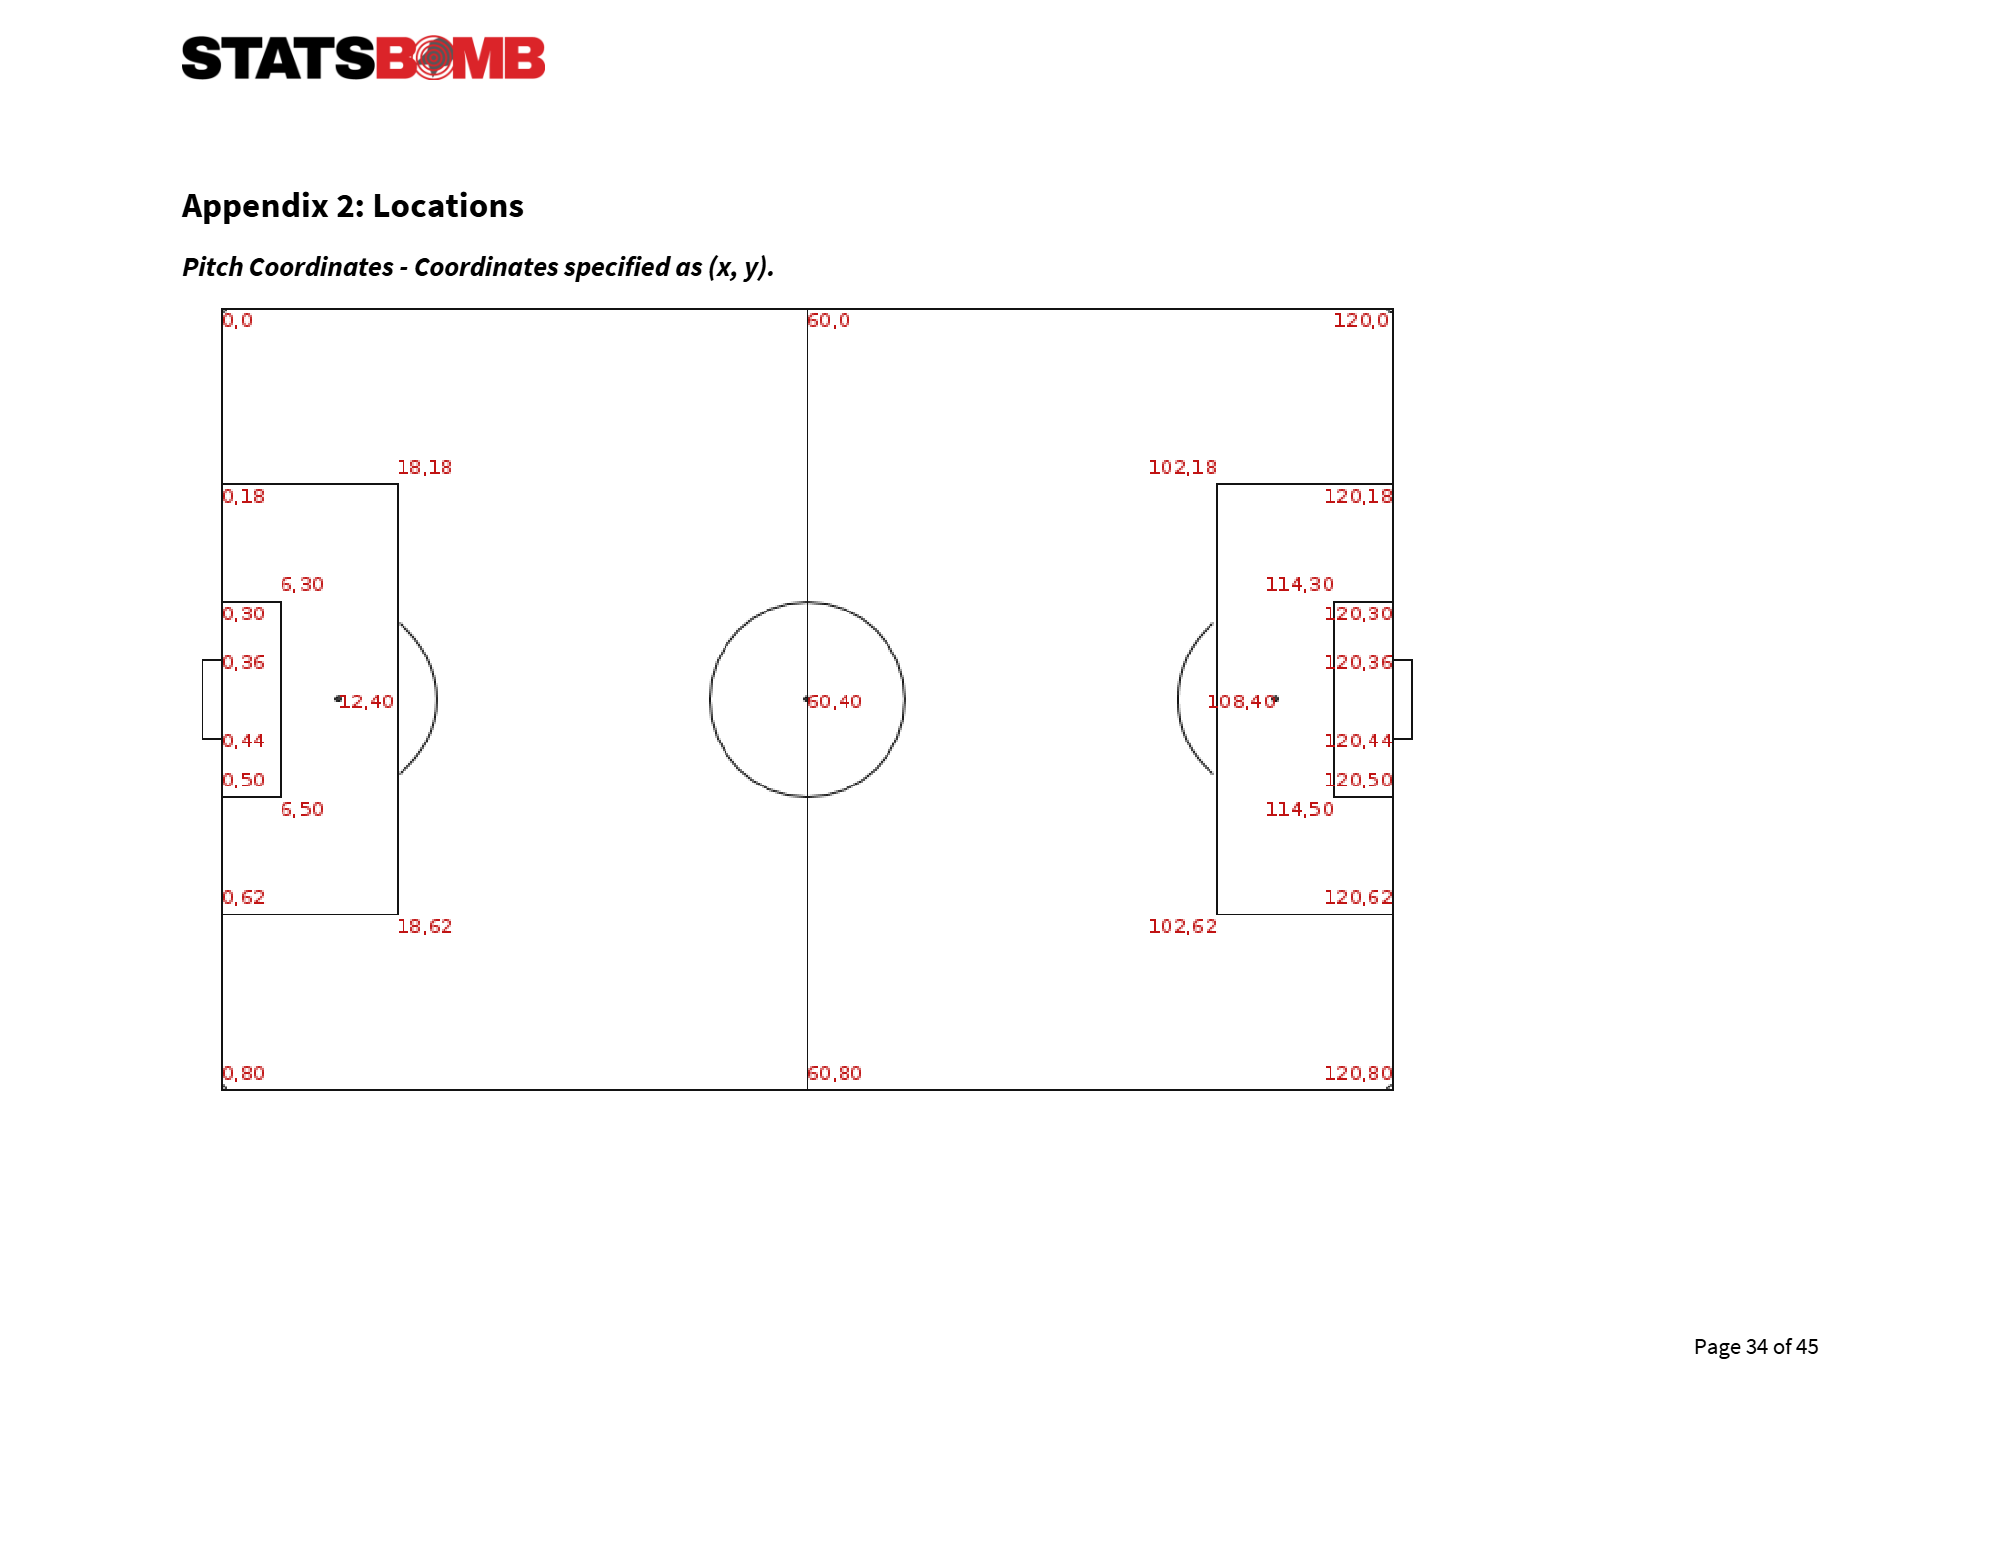

In [ ]:
# Define lines for pitch for heatmaps etc.
pitchLength = 120
pitchWidth = 80
touchLineDimensionsX = [0,pitchLength,pitchLength,0,0]
touchLineDimensionsY = [pitchWidth,pitchWidth,0,0,pitchWidth]
centrelineX = [pitchLength/2,pitchLength/2]
centrelineY = [0,pitchWidth]
goalLineX = [0,0]
goalLineX_2nd = [pitchLength,pitchLength]
goalLineY = [36,44]
smallBoxX = [0,6,6,0]
smallBoxX_2nd = [pitchLength,pitchLength-6,pitchLength-6,pitchLength]
smallBoxY = [30,30,50,50]
bigBoxX = [0,18,18,0]
bigBoxX_2nd = [pitchLength,pitchLength-18,pitchLength-18,pitchLength]
bigBoxY = [18,18,62,62]
circleBottomLeft = [50,30]
circleTopRight = [70,50]
penaltySpot = [12,40]
centerSpot = [60,40]

# Plot Player Specific Data for a Game

In [ ]:
player = 'Marcus Rashford'
playerSpecificData = matchData[(matchData['player']==player) & (matchData['actor']==True)]
print(list(playerSpecificData.type.unique()))
playerSpecificData[['X','Y']] = pd.DataFrame(playerSpecificData.location_x.tolist(),index=playerSpecificData.index)


['Ball Receipt*', 'Carry', 'Pass', 'Ball Recovery', 'Shot', 'Dribble', 'Duel', 'Miscontrol', 'Pressure']


In [ ]:
# Add visible area polygon to each frame
frames = []
sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "steps":[]}
#for frameNum, frame in enumerate(fig.frames):
for frameNum in range(0,len(playerSpecificData.id.unique())):
    currentVisibleArea = playerSpecificData.iloc[frameNum].visible_area
    xVals = currentVisibleArea[::2]
    yVals = currentVisibleArea[1::2]
    if frameNum ==0:
      pitchData = [
      go.Scatter(x = xVals, y = yVals, fill="toself"),
      go.Scatter(x=[playerSpecificData.iloc[frameNum].X], y=[playerSpecificData.iloc[frameNum].Y], mode='markers', marker=dict(color='red', size=10)) ,
      go.Scatter(x=touchLineDimensionsX,y=touchLineDimensionsY,mode='lines',line=dict(color="white")),
      go.Scatter(x=touchLineDimensionsX,y=touchLineDimensionsY,mode='lines',line=dict(color="white")),
      go.Scatter(x=goalLineX,y=goalLineY,mode='lines',line=dict(color="red")),
      go.Scatter(x=goalLineX_2nd,y=goalLineY,mode='lines',line=dict(color="red")),
      go.Scatter(x=smallBoxX,y=smallBoxY,mode='lines',line=dict(color="white")),
      go.Scatter(x=bigBoxX,y=bigBoxY,mode='lines',line=dict(color="white")),
      go.Scatter(x=centrelineX,y=centrelineY,mode='lines',line=dict(color="white")),
      go.Scatter(x=smallBoxX_2nd,y=smallBoxY,mode='lines',line=dict(color="white")),
      go.Scatter(x=bigBoxX_2nd,y=bigBoxY,mode='lines',line=dict(color="white"))
  ]


    frames.append(go.Frame(data=[
        go.Scatter(x = xVals, y = yVals, fill="toself"),
        go.Scatter(x=[playerSpecificData.iloc[frameNum].X], y=[playerSpecificData.iloc[frameNum].Y], mode='markers', marker=dict(color='red', size=10)) ,
            go.Scatter(x=touchLineDimensionsX,y=touchLineDimensionsY,mode='lines',line=dict(color="white")),
    go.Scatter(x=touchLineDimensionsX,y=touchLineDimensionsY,mode='lines',line=dict(color="white")),
    go.Scatter(x=goalLineX,y=goalLineY,mode='lines',line=dict(color="red")),
    go.Scatter(x=goalLineX_2nd,y=goalLineY,mode='lines',line=dict(color="red")),
    go.Scatter(x=smallBoxX,y=smallBoxY,mode='lines',line=dict(color="white")),
    go.Scatter(x=bigBoxX,y=bigBoxY,mode='lines',line=dict(color="white")),
    go.Scatter(x=centrelineX,y=centrelineY,mode='lines',line=dict(color="white")),
    go.Scatter(x=smallBoxX_2nd,y=smallBoxY,mode='lines',line=dict(color="white")),
    go.Scatter(x=bigBoxX_2nd,y=bigBoxY,mode='lines',line=dict(color="white")),

    ],name=frameNum))
    slider_step = {"args": [
        [frameNum],
        {"frame": {"duration": 300, "redraw": False},
         "mode": "immediate",
         "transition": {"duration": 300}}
    ],
        "label": frameNum,
        "method": "animate"}
    sliders_dict["steps"].append(slider_step)



fig = go.Figure(data = pitchData,frames = frames,layout=go.Layout(
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None])])],
        sliders = [sliders_dict],
    ),)

fig.update_layout(yaxis_range=[-1,pitchWidth/1],
                  xaxis_range=[-1,pitchLength+1],
                  yaxis=dict(scaleanchor="x", scaleratio=1),
                  showlegend=False,plot_bgcolor='green' )
#fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 100
#fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 10
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)


fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=51.85, y0=30.85, x1=69.15, y1=49.15,
    line_color="White",
)


fig.show()

# Plot all players for each frame

In [ ]:
frameIDs = matchData.id.unique()

# Add visible area polygon to each frame
frames = []
sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "steps":[]}

framesToShow = int(len(frameIDs))

for frameNum in range(0,framesToShow):
    # Create local df just with current frame and add plotColor and symbols
    localDf = matchData[matchData['id']==frameIDs[frameNum]]
    localDf[['X','Y']] = pd.DataFrame(localDf.location_x.tolist(),index=localDf.index)

    currentVisibleArea = localDf.iloc[0].visible_area
    xVals = currentVisibleArea[::2]
    yVals = currentVisibleArea[1::2]

    tempFig = px.scatter(localDf,x='X',y='Y',color='plotColor',symbol='plotSymbol')

    if frameNum ==0:
      pitchData = [
      go.Scatter(x = xVals, y = yVals, fill="toself"),
      tempFig.data[0],
      go.Scatter(x=touchLineDimensionsX,y=touchLineDimensionsY,mode='lines',line=dict(color="white")),
      go.Scatter(x=touchLineDimensionsX,y=touchLineDimensionsY,mode='lines',line=dict(color="white")),
      go.Scatter(x=goalLineX,y=goalLineY,mode='lines',line=dict(color="red")),
      go.Scatter(x=goalLineX_2nd,y=goalLineY,mode='lines',line=dict(color="red")),
      go.Scatter(x=smallBoxX,y=smallBoxY,mode='lines',line=dict(color="white")),
      go.Scatter(x=bigBoxX,y=bigBoxY,mode='lines',line=dict(color="white")),
      go.Scatter(x=centrelineX,y=centrelineY,mode='lines',line=dict(color="white")),
      go.Scatter(x=smallBoxX_2nd,y=smallBoxY,mode='lines',line=dict(color="white")),
      go.Scatter(x=bigBoxX_2nd,y=bigBoxY,mode='lines',line=dict(color="white"))]

    frames.append(go.Frame(data=[
        go.Scatter(x = xVals, y = yVals, fill="toself"),
        tempFig.data[0],
        go.Scatter(x=touchLineDimensionsX,y=touchLineDimensionsY,mode='lines',line=dict(color="white")),
        go.Scatter(x=touchLineDimensionsX,y=touchLineDimensionsY,mode='lines',line=dict(color="white")),
        go.Scatter(x=goalLineX,y=goalLineY,mode='lines',line=dict(color="red")),
        go.Scatter(x=goalLineX_2nd,y=goalLineY,mode='lines',line=dict(color="red")),
        go.Scatter(x=smallBoxX,y=smallBoxY,mode='lines',line=dict(color="white")),
        go.Scatter(x=bigBoxX,y=bigBoxY,mode='lines',line=dict(color="white")),
        go.Scatter(x=centrelineX,y=centrelineY,mode='lines',line=dict(color="white")),
        go.Scatter(x=smallBoxX_2nd,y=smallBoxY,mode='lines',line=dict(color="white")),
        go.Scatter(x=bigBoxX_2nd,y=bigBoxY,mode='lines',line=dict(color="white")),
    ],name=frameNum))
    slider_step = {"args": [
        [frameNum],
        {"frame": {"duration": 300, "redraw": False},
         "mode": "immediate",
         "transition": {"duration": 300}}
    ],
        "label": frameNum,
        "method": "animate"}
    sliders_dict["steps"].append(slider_step)


fig = go.Figure(data = pitchData,frames = frames,layout=go.Layout(
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None])])],
        sliders = [sliders_dict],
    ),)

fig.update_layout(yaxis_range=[-1,pitchWidth/1],
                  xaxis_range=[-1,pitchLength+1],
                  yaxis=dict(scaleanchor="x", scaleratio=1),
                  showlegend=False,plot_bgcolor='green' )
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)


fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=51.85, y0=30.85, x1=69.15, y1=49.15,
    line_color="White",
)

fig.write_html('test.html')
fig.show()

